# Punctuation tasks
In thesetasks we have to predict commas in given sentences.

In [1]:
%reload_ext autoreload
%autoreload 2

from warnings import filterwarnings
filterwarnings('ignore')

# Part I. Data processing
My model will be based on assumptions that according to the words before the comma, as well as parts of the speech of several words surrounding the comma, it is possible to identify well the need for its setting. 

To train the model we have to find suitable dataset with a huge number of long complicated sentences. I think, in this case the text of any novel of Dostoevsky Fedor Mikhailovichis perfectly suited! :)

In [2]:
from sberbank_baseline.data_processing import NgramManager
ngram_man = NgramManager()

In [3]:
from code_snippets.data_processing import get_sentences_from_text, sentance_to_windows, vectorizer
from code_snippets.utils import MyMorph

In [4]:
# divide the text into sentences
sentences = get_sentences_from_text('data/Dostoevskiyi_F._Idiot.txt', min_symbols_in_sent=10)
print(*sentences[:4], sep='\n\n')

часть первая

в конце ноября, в оттепель, часов в девять утра, поезд петербургско-варшавской железной дороги на всех парах подходил к петербургу

 было так сыро и туманно, что насилу рассвело; в десяти шагах, вправо и влево от дороги, трудно было разглядеть хоть что-нибудь из окон вагона

 из пассажиров были и возвращавшиеся из-за границы; но более были наполнены отделения для третьего класса, и всё людом мелким и деловым, не из очень далека


In [5]:
# transform sentences to windows of words contained main word (before the comma) and 5 words back and 5 words forward
word_windows = []
for sentence in sentences:
    word_windows += sentance_to_windows(sentence, n_backw=5, n_frontw=5)
    
print(*word_windows[:4], sep='\n\n')

([], 'в', ['конце', 'ноября,', 'в', 'оттепель,', 'часов'])

(['в'], 'конце', ['ноября,', 'в', 'оттепель,', 'часов', 'в'])

(['в', 'конце'], 'ноября,', ['в', 'оттепель,', 'часов', 'в', 'девять'])

(['в', 'конце', 'ноября,'], 'в', ['оттепель,', 'часов', 'в', 'девять', 'утра,'])


In [6]:
# turn word windows into features: save words' part of speach, case and aspect
# add ngram frequencies as features: find out how often ngram occurs with and wo comma
# if any tag of word classifies it as Function word, save it as additional feature
import pandas as pd
morph = MyMorph()
X_df = pd.DataFrame([vectorizer(ww, morph, ngram_man) for ww in word_windows])

In [7]:
X_df.shape

(204388, 32)

In [8]:
# X_df.to_csv('data/X_df.csv', index=False)
X_df = pd.read_csv('data/X_df.csv')

In [9]:
X_df[['b_1_tag', 'f_1_tag', 'f_1_word', 'main_aspect', 'main_case', 'main_tag', 'main_word', 'y']].head(4)

,b_1_tag,f_1_tag,f_1_word,main_aspect,main_case,main_tag,main_word,y
0,NaN,NOUN,NaN,NaN,NaN,PREP,в,0
1,PREP,NOUN,NaN,NaN,loct,NOUN,NaN,0
2,NOUN,PREP,в,NaN,gent,NOUN,NaN,1
3,NOUN,NOUN,NaN,NaN,NaN,PREP,в,0


In [10]:
# Get dummies from dataset to put it into model
X_df = pd.get_dummies(X_df).fillna(0)

In [11]:
X_df.shape

(204388, 720)

In [12]:
X_df[[
    'b_1_tag_PREP', 'b_1_tag_NOUN', 'f_1_tag_PREP', 'f_1_tag_NOUN', 
    'f_1_word_в', 'main_word_в', 
    'y'
]].head(4)

,b_1_tag_PREP,b_1_tag_NOUN,f_1_tag_PREP,f_1_tag_NOUN,f_1_word_в,main_word_в,y
0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0
2,0,1,1,0,1,0,1
3,0,1,0,1,0,1,0


In [13]:
y = X_df.y
X_df.drop('y', axis=1, inplace=True)
X_df['weight'] = 1

Huge number of long complicated centences is good, but if we add task specified centences, we can get a better model. 

In [14]:
import pickle
with open('data/y_tasks', 'rb') as file:
    y_tasks = pickle.load(file)

with open('data/train_tasks', 'rb') as file:
    train_tasks = pickle.load(file)

In [15]:
# Add data in same format from tasks found in web with 5 times larger weight
X1_df = pd.DataFrame([vectorizer(ww, morph, ngram_man) for ww in train_tasks])
X1_df = pd.get_dummies(X1_df).fillna(0)
X1_df.drop('y', axis=1, inplace=True)
X1_df['weight'] = 5

In [16]:
X_df = X_df.append(X1_df).fillna(0)
y = pd.Series(list(y)+y_tasks)

In [17]:
y.value_counts()

0    175554
1     33055
dtype: int64

# Part II. Modelling

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold

In [105]:
# split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.15)

W_train = X_train['weight']
X_train.drop('weight', axis=1, inplace=True)
W_val = X_val['weight']
X_val.drop('weight', axis=1, inplace=True)

In [106]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [107]:
X_train.shape

(177317, 757)

In [108]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {k: v for k, v in enumerate(class_weights)}
class_weights

{0: 0.5943772542604685, 1: 3.148943349316285}

In [109]:
# building a model with keras
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import ProgbarLogger
from keras import backend as K 

K.clear_session()
model = Sequential()  

model.add(Dense(40, input_shape=(X_train.shape[1],), init = 'uniform')) 
model.add(Dropout(.3))
model.add(Activation('relu'))

model.add(Dense(10, init = 'uniform'))
model.add(Dropout(.1))
model.add(Activation('relu'))

model.add(Dense(1, init = 'uniform'))
model.add(Activation('sigmoid'))

/Users/darya.guselnikova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, input_shape=(757,), kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/Users/darya.guselnikova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="uniform")`
  
/Users/darya.guselnikova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                30320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [111]:
from keras.callbacks import Callback, EarlyStopping
my_callbacks = [EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')]

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [112]:
history = model.fit(
    X_train, 
    y_train,
    batch_size=64, 
    epochs=100,
    validation_data=(X_val, y_val, W_val.values),
    verbose=2,
    class_weight=class_weights,
    callbacks=my_callbacks,
    sample_weight=W_train.values
)

Train on 177317 samples, validate on 31292 samples
Epoch 1/100
 - 19s - loss: 0.5572 - accuracy: 0.7117 - val_loss: 0.5055 - val_accuracy: 0.7775
Epoch 2/100
 - 19s - loss: 0.4956 - accuracy: 0.7710 - val_loss: 0.5353 - val_accuracy: 0.7553
Epoch 3/100
 - 18s - loss: 0.4677 - accuracy: 0.7835 - val_loss: 0.4874 - val_accuracy: 0.8005
Epoch 4/100
 - 22s - loss: 0.4495 - accuracy: 0.7925 - val_loss: 0.4910 - val_accuracy: 0.8018
Epoch 5/100
 - 22s - loss: 0.4379 - accuracy: 0.7966 - val_loss: 0.4669 - val_accuracy: 0.8039
Epoch 6/100
 - 37s - loss: 0.4293 - accuracy: 0.8002 - val_loss: 0.5186 - val_accuracy: 0.7869
Epoch 7/100
 - 17s - loss: 0.4248 - accuracy: 0.8001 - val_loss: 0.4499 - val_accuracy: 0.8151
Epoch 8/100
 - 19s - loss: 0.4192 - accuracy: 0.7967 - val_loss: 0.4498 - val_accuracy: 0.7968
Epoch 9/100
 - 19s - loss: 0.4160 - accuracy: 0.7907 - val_loss: 0.4736 - val_accuracy: 0.7872
Epoch 10/100
 - 18s - loss: 0.4128 - accuracy: 0.7936 - val_loss: 0.4426 - val_accuracy: 0.803

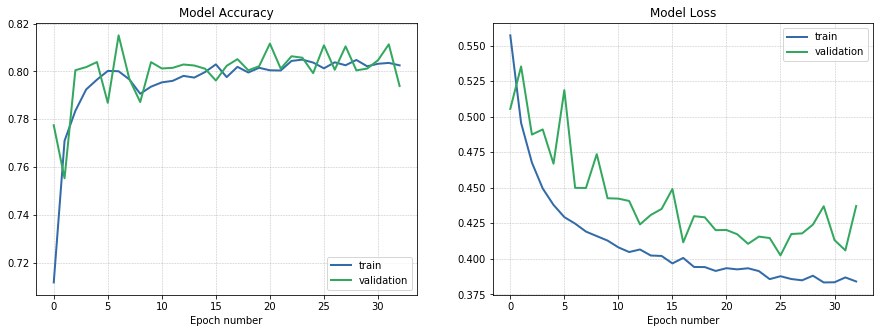

In [113]:
%matplotlib inline
from code_snippets.utils import plot_learning_metrics

plot_learning_metrics(history)

During the analysis of the model results on test tasks, I found out that it skips commas more often in the right places than puts extra ones. Therefore, we need to select a lower threshold of probability.

# Part III. Apply model on tasks

In [124]:
from code_snippets.checker import Checker, check_solution
test_checker = Checker('data/check-v2', is_nested=False)

In [135]:
# saved task accuracy for different thresholds
# for t in answers:
#     print(t, np.mean(answers[t]))

0.1 0.25
0.2 0.175
0.3 0.175
0.4 0.15
0.5 0.2
0.6 0.1


Here are results of model application on test tasks. The results are quite good for such a simple model: 25 % of tasks were solved write for all commas. Most tasks are partly correct.

In [136]:
from code_snippets.model_testing import test_model

X_df_columns = X_df.drop('weight', axis=1).columns
answers = test_model(model, test_checker, morph, ngram_man, thresholds=[.1], X_df_columns=X_df_columns)

Predictions for threshold: 0.1

Расставьте знаки препинания.
Несмотря на осеннюю прохладу (1) он решил отдохнуть в лесу и прилёг на одном из незаросших мест (2) сплошь усыпанном (3) золотыми листьями (4) налетевшими на полянку с (5) окаймлявших её (6) деревьев.
Укажите цифру(-ы), на месте которой(-ых) должна(-ы) стоять запятая(-ые).
{'prediction': [1, 2]}
{'correct': ['1', '2', '4']}

Расставьте все знаки препинания: укажите цифру(-ы), на месте которой(-ых) в предложении должна(-ы) стоять запятая(-ые). Перифраза — оборот речи, который состоит в замене слова описательным сочетанием (1) содержащим (2) элемент характеристики описываемого предмета или лица (3) и помогающим (4) избежать неоправданных повторов в тексте.
{'prediction': [1, 3]}
{'correct': ['1']}

Расставьте все знаки препинания: укажите цифру(-ы), на месте которой(-ых) в предложении должна(-ы) стоять запятая(-ые). Под солнцем (1) соперничая с ним (2) ярко светились необыкновенно высокие, сочные и крупноцветные купальницы (3) 

Расставьте все знаки препинания: укажите цифру(-ы), на месте которой(-ых) в предложении должна(-ы) стоять запятая(-ые). Для понимания вашего конспекта (1) необходимо иметь перед глазами ту книгу (2) по поводу (3) которой (4) сделаны заметки.
{'prediction': [1]}
{'correct': ['2']}

Расставьте все знаки препинания: укажите цифру(-ы), на месте которой(-ых) в предложении должна(-ы) стоять запятая(-ые). Тем временем (1) пожилой хозяин (2) на лице (3) которого (4) было написано истинное добродушие (5) с искренним участием расспрашивал меня о путешествии.
{'prediction': [1, 2, 5]}
{'correct_variants': [['2', '5'], ['5', '2']]}

Расставьте все знаки препинания: укажите цифру(-ы), на месте которой(-ых) в предложении должна(-ы) стоять запятая(-ые). Солнечным и ясным утром Володя и Лида шли по красивой аллее (1) в глубине (2) которой (3) виднелось двухэтажное белое здание (4) и мило беседовали.
{'prediction': [1, 4]}
{'correct_variants': [['1', '4'], ['4', '1']]}

Расставьте знаки препинания: ука